In [1]:
%pip install numpy matplotlib scipy


[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [1]:
# Ruta de las imágenes (modificar con las rutas reales)
intra_focal_path = "images/Intrafocal-0033R.fit"
extra_focal_path = "images/Extrafocal-0017R.fit"

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import fft2, fftshift
from astropy.io import fits

# Cargar las imágenes FITS
with fits.open("images/Intrafocal-0033R.fit") as hdul:
        img = hdul[0].data

img = preprocess_and_center_image_debug(img, threshold)
img = crop_to_center(img, crop_size)
# Crear una imagen de prueba (patrón circular simulado como ejemplo óptico)
x = np.linspace(-1, 1, 256)
y = np.linspace(-1, 1, 256)
X, Y = np.meshgrid(x, y)


# Calcular la transformada de Fourier
fft_result = fft2(img)
fft_shifted = fftshift(fft_result)

# Magnitud y fase de la transformada
magnitude_spectrum = np.log(1 + np.abs(fft_shifted))
phase_spectrum = np.angle(fft_shifted)

# Visualizar la imagen original y las representaciones en el dominio de Fourier
plt.figure(figsize=(12, 8))

# Imagen original
plt.subplot(1, 3, 1)
plt.imshow(img, cmap='gray')
plt.title("Imagen Original (Espacio)")
plt.axis('off')

# Espectro de Magnitud
plt.subplot(1, 3, 2)
plt.imshow(magnitude_spectrum, cmap='viridis')
plt.title("Espectro de Magnitud (Frecuencias)")
plt.axis('off')

# Espectro de Fase
plt.subplot(1, 3, 3)
plt.imshow(phase_spectrum, cmap='twilight')
plt.title("Espectro de Fase")
plt.axis('off')

plt.tight_layout()
plt.show()


NameError: name 'preprocess_and_center_image_debug' is not defined

Centrando imágenes...
Centro detectado: (np.float64(656.154410770247), np.float64(548.805597291528))
Centro detectado: (np.float64(654.5904404443868), np.float64(555.3635729085305))


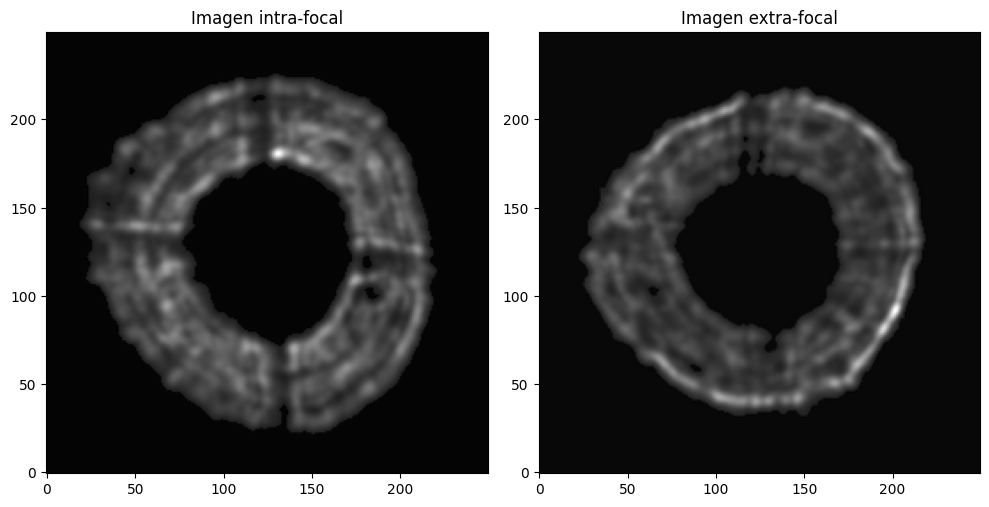

(250, 250) (250, 250) (250, 250)


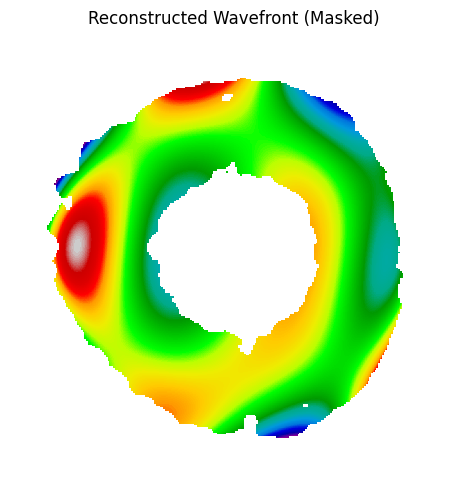

Coeficientes de Zernike:
1. Piston: -0.0322
2. Tilt X: 0.1239
3. Tilt Y: -0.0089
4. Defocus: -0.0259
5. Astigmatism 45°: -0.0257
6. Astigmatism 0°: 0.0139
7. Coma X: 0.0009
8. Coma Y: 0.1332
9. Trefoil X: -0.0848
10. Trefoil Y: 0.0827
11. Spherical Aberration: -0.0281
12. Secondary Astigmatism 0°: 0.0097
13. Secondary Astigmatism 45°: -0.0115
14. Secondary Coma X: 0.0378
15. Secondary Coma Y: -0.0101
16. Tertiary Spherical: 0.1241
17. Secondary Trefoil X: -0.0081
18. Secondary Trefoil Y: 0.0458
19. Pentafoil X: -0.0393
20. Pentafoil Y: -0.0785
21. Higher-Order Spherical: 0.0341


In [4]:
from calendar import c
from matplotlib.pylab import f
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import center_of_mass, shift
from scipy.fft import fftshift, fft2
from astropy.io import fits
from zernike import RZern
from scipy.ndimage import gaussian_filter


def load_fits_image(file_path):
    """Carga la imagen FITS y retorna los datos como un arreglo numpy."""
    try:
        with fits.open(file_path) as hdul:
            img_data = hdul[0].data
            return img_data
    except Exception as e:
        print(f"Error cargando la imagen FITS {file_path}: {e}")
        return None


def plot_loaded_images(img1, img2):
    """Muestra las imágenes cargadas para verificar."""
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    axs[0].imshow(img1, cmap="gray", origin="lower")
    axs[0].set_title("Imagen intra-focal")

    axs[1].imshow(img2, cmap="gray", origin="lower")
    axs[1].set_title("Imagen extra-focal")

    plt.tight_layout()
    plt.show()


def calculate_radii(img):
    """
    Calcula los radios interno y externo para la máscara anular.

    Parameters:
        img (numpy.ndarray): La imagen procesada.

    Returns:
        inner_radius (float): Radio interno normalizado (0 a 1).
        outer_radius (float): Radio externo normalizado (0 a 1).
    """
    ny, nx = img.shape
    y, x = np.indices((ny, nx))
    center_y, center_x = ny // 2, nx // 2
    R = np.sqrt((x - center_x)**2 + (y - center_y)**2)

    # Calcula radios basados en datos válidos
    inner_radius = np.min(R[img > 0]) / (nx // 2)
    outer_radius = np.max(R[img > 0]) / (nx // 2)
    print(f"Inner Radius: {inner_radius:.2f}, Outer Radius: {outer_radius:.2f}")
    return inner_radius, outer_radius

def filter_noise(img, gaussian_sigma=1, threshold_ratio=0.1):
    """
    Filtra el ruido en una imagen utilizando un filtro Gaussiano y un umbral adaptativo.

    Parameters:
        img (numpy.ndarray): Imagen de entrada.
        gaussian_sigma (float): Desviación estándar para el filtro Gaussiano.
        threshold_ratio (float): Proporción del valor máximo de la imagen para el umbral.

    Returns:
        filtered_img (numpy.ndarray): Imagen filtrada.
    """
    if img is None:
        raise ValueError("La imagen no es válida o está vacía.")

    # Suavizado Gaussiano para reducir el ruido
    smoothed_img = gaussian_filter(img, sigma=gaussian_sigma)

    # Normalización de la imagen
    smoothed_img = smoothed_img / np.max(smoothed_img)

    # Aplicar un umbral adaptativo
    threshold = threshold_ratio * np.max(smoothed_img)
    binary_mask = smoothed_img > threshold
    filtered_img = smoothed_img * binary_mask

    return filtered_img


def center_image(img):
    """Centra la estrella en la imagen utilizando el centro de masa."""
    if img is None:
        raise ValueError("La imagen es inválida o no se cargó correctamente.")

    # Encuentra el centroide (centro de masa)
    center = center_of_mass(img)
    img_center = np.array(img.shape) // 2
    print(f"Centro de masa de la estrella: {center}")
    print(f"Centro de la imagen: {img_center}")
    # Calcula el desplazamiento necesario
    shift_values = img_center - center

    # Aplica el desplazamiento para centrar la estrella
    centered_img = shift(img, shift_values, mode='constant', cval=0)
    return centered_img

def preprocess_and_center_image_debug(img):
    """
    Centra la estrella en la imagen utilizando el centro de masa,
    aplicando un umbral para eliminar ruido y mostrando pasos intermedios.

    Parameters:
        img (numpy.ndarray): La imagen a procesar.
        threshold (float): Proporción del valor máximo para establecer el umbral.
    Returns:
        centered_img (numpy.ndarray): Imagen centrada.
    """
    if img is None:
        raise ValueError("La imagen es inválida o no se cargó correctamente.")


    binary_mask = img > threshold
    filtered_img = img * binary_mask

    # Encuentra el centro de masa de la región filtrada
    center = center_of_mass(img)
    print(f"Centro detectado: {center}")


    # Calcula el desplazamiento necesario
    img_center = np.array(img.shape) // 2
    shift_values = img_center - center

    # Aplica el desplazamiento
    centered_img = shift(img, shift_values, mode="constant", cval=0)

    return centered_img

def crop_to_center(img, size):
    """Recorta la imagen para centrarse en el área relevante."""
    if img is None:
        raise ValueError("La imagen es inválida o no se cargó correctamente.")
    center = np.array(img.shape) // 2
    half_size = size // 2
    return img[center[0] - half_size:center[0] + half_size,
               center[1] - half_size:center[1] + half_size]


def calculate_phase(img1, img2):
    """Calcula el frente de onda (wavefront) a partir de las imágenes."""
    if img1.shape != img2.shape:
        raise ValueError("Las imágenes deben tener el mismo tamaño.")
    fft_intra = fftshift(fft2(img1))
    fft_extra = fftshift(fft2(img2))

    # Evitar divisiones por cero
    with np.errstate(divide='ignore', invalid='ignore'):
        phase_diff = np.angle(np.divide(fft_extra, fft_intra, out=np.zeros_like(fft_intra), where=fft_intra != 0))

    return phase_diff


def calculate_wavefront_zernike(phase_diff, mask, num_terms=10):
    """Calcula los coeficientes de Zernike a partir de la diferencia de fase."""
    ny, nx = phase_diff.shape
    x = np.linspace(-1, 1, nx)
    y = np.linspace(-1, 1, ny)
    X, Y = np.meshgrid(x, y)
    R = np.sqrt(X**2 + Y**2)
    print(X.shape, Y.shape, R.shape)
    wavefront_masked = np.where(mask, phase_diff, np.nan)

    if np.sum(mask) == 0:
        raise ValueError("La máscara no contiene datos válidos.")

    # Ajuste de Zernike
    zern = RZern(num_terms)
    zern.make_cart_grid(X, Y)

    zernike_coeffs = zern.fit_cart_grid(wavefront_masked)[0]
    Phi_reconstructed = zern.eval_grid(zernike_coeffs, matrix=True)
    Phi_reconstructed_masked = np.where(mask, Phi_reconstructed, np.nan)

    plot_zernike_coefficients(zernike_coeffs, Phi_reconstructed_masked)

    return zernike_coeffs

def plot_zernike_coefficients(coefficients, phi_reconstructed_masked):
    """
    Genera un gráfico y tabla de los coeficientes de Zernike.

    Parameters:
        coefficients (list): Lista de coeficientes de Zernike.
    """
    # Etiquetas para los primeros 15 polinomios de Zernike
    labels = [
    "Piston",                   # Z1 (0, 0)
    "Tilt X",                   # Z2 (1, -1)
    "Tilt Y",                   # Z3 (1, 1)
    "Defocus",                  # Z4 (2, 0)
    "Astigmatism 45°",          # Z5 (2, -2)
    "Astigmatism 0°",           # Z6 (2, 2)
    "Coma X",                   # Z7 (3, -1)
    "Coma Y",                   # Z8 (3, 1)
    "Trefoil X",                # Z9 (3, -3)
    "Trefoil Y",                # Z10 (3, 3)
    "Spherical Aberration",     # Z11 (4, 0)
    "Secondary Astigmatism 0°", # Z12 (4, -2)
    "Secondary Astigmatism 45°",# Z13 (4, 2)
    "Secondary Coma X",         # Z14 (4, -4)
    "Secondary Coma Y",         # Z15 (4, 4)
    "Tertiary Spherical",       # Z16 (5, 0)
    "Secondary Trefoil X",      # Z17 (5, -1)
    "Secondary Trefoil Y",      # Z18 (5, 1)
    "Pentafoil X",              # Z19 (5, -5)
    "Pentafoil Y",              # Z20 (5, 5)
    "Higher-Order Spherical"    # Z21 (6, 0)
]



    plt.figure(figsize=(7, 5))

    plt.imshow(phi_reconstructed_masked, origin='lower', extent=(-1, 1, -1, 1), cmap="nipy_spectral")
    plt.title("Reconstructed Wavefront (Masked)")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    # Crear una tabla con los coeficientes
    print("Coeficientes de Zernike:")
    for i, (label, coeff) in enumerate(zip(labels, coefficients)):
        print(f"{i + 1}. {label}: {coeff:.4f}")

def roddier_test_with_zernike(intra_path, extra_path, crop_size, threshold=0.1, num_terms=10):
    """Realiza el test de Roddier con análisis de Zernike."""
    intra_img = load_fits_image(intra_path)
    extra_img = load_fits_image(extra_path)

    if intra_img is None or extra_img is None:
        raise ValueError("Una o ambas imágenes no se cargaron correctamente.")

    print("Centrando imágenes...")
    intra_img = filter_noise(intra_img, threshold_ratio=threshold)
    extra_img = filter_noise(extra_img, threshold_ratio=threshold)
    intra_img = preprocess_and_center_image_debug(intra_img)
    extra_img = preprocess_and_center_image_debug(extra_img)
    intra_img = crop_to_center(intra_img, crop_size)
    extra_img = crop_to_center(extra_img, crop_size)
    plot_loaded_images(intra_img, extra_img)
    phase_diff = calculate_phase(intra_img, extra_img)
    image_sum = intra_img + extra_img

    image_sum = image_sum / np.max(image_sum)

    # Aplica un umbral para generar una máscara binaria
    binary_mask = image_sum > threshold
    zernike_coeffs = calculate_wavefront_zernike(phase_diff, binary_mask, num_terms)
    return zernike_coeffs

# Parámetros
intra_focal_path = "images/Intrafocal-0033R.fit"
extra_focal_path = "images/Extrafocal-0017R.fit"
crop_size = 250
threshold = 0.1
num_terms = 5

# Ejecutar test
try:
    zernike_coeffs = roddier_test_with_zernike(intra_focal_path, extra_focal_path, crop_size, threshold, num_terms)

except Exception as e:
    print(f"Error en el Test de Roddier: {e}")

In [65]:
%pip install ipywidgets

  Obtaining dependency information for ipywidgets from https://files.pythonhosted.org/packages/22/2d/9c0b76f2f9cc0ebede1b9371b6f317243028ed60b90705863d493bae622e/ipywidgets-8.1.5-py3-none-any.whl.metadata
  Obtaining dependency information for widgetsnbextension~=4.0.12 from https://files.pythonhosted.org/packages/21/02/88b65cc394961a60c43c70517066b6b679738caf78506a5da7b88ffcb643/widgetsnbextension-4.0.13-py3-none-any.whl.metadata
  Obtaining dependency information for jupyterlab-widgets~=3.0.12 from https://files.pythonhosted.org/packages/a9/93/858e87edc634d628e5d752ba944c2833133a28fa87bb093e6832ced36a3e/jupyterlab_widgets-3.0.13-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 1.9 MB/s eta 0:00:00 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 214.4/214.4 kB 4.6 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 16.4 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] T

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from ipywidgets import interact, Checkbox, IntSlider, HBox, VBox, interactive_output
from matplotlib import cm

def visualize_zernike(selected_terms):
    """
    Combina y visualiza polinomios de Zernike seleccionados.
    """
    combined_wavefront = np.zeros_like(mask, dtype=float)
    for term in selected_terms:
        if term < len(zernike_coeffs):
            combined_wavefront += zernike_basis[term]

    # Visualización del frente de onda combinado
    plt.figure(figsize=(6, 6))
    plt.imshow(combined_wavefront, cmap='nipy_spectral', origin='lower', extent=(-1, 1, -1, 1))
    plt.colorbar(label="Amplitud")
    plt.title(f"Polinomios de Zernike seleccionados: {selected_terms}")
    plt.axis("off")
    plt.show()

# Crear una lista de selección interactiva
checkboxes = [Checkbox(description=f"Z{n}", value=False) for n in range(num_terms)]

def update_plot(*args):
    """
    Actualiza el gráfico basado en los términos seleccionados.
    """
    zernike_coeffs = [i for i, checkbox in enumerate(checkboxes) if checkbox.value]
    visualize_zernike(zernike_coeffs)

# Conectar los widgets al gráfico
for checkbox in checkboxes:
    checkbox.observe(update_plot, 'value')

# Display interactivo
VBox(checkboxes)